# Was the Banking Marketing Campaign Successful?

![](images/kurt.jpeg)

**OVERVIEW**

The goal of this analysis is to assess various Classification modeling approaches for assessing the effectiveness of a bank marketing campaign.  The classification goal is to predict if a customer will subscribe to a 'term deposit' banking product (yes/no for variable y).

#### DATA OVERVIEW




The dataset being analyzed is from the UCI Machine Learning repository (https://archive.ics.uci.edu/ml/datasets/bank+marketing). The data is from a Portuguese banking institution and is a collection of the results of multiple marketing campaigns. The feature data available includes: 
* customer's age
* job type
* marital status
* education level
* credit status (default yes/no)
* housing loan status
* personal loan status
* contact information
* campaign information

### Standard Package Imports

In [71]:
# Import all the packages that might be needed
import os 

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import plotly.express as px
import plotly.graph_objs as go
import plotly.io as pio

import sklearn
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline

from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid

!pip install imblearn
from imblearn.under_sampling import RandomUnderSampler




### Business Understanding

From a business perspective, the business task was to understand the key drivers for a past banking marketing campaign. 

Given a dataset containing 45,211 rows of data and 20 feature variables, ordered by data from May 2008 to November 2010. Exploratory data analysis was done to clean the data, visualize the data and determine the strongest influencing features that drove the successful sale of the term deposit bank product.  Most of the data needed to be cleaned and the categorical data converted to some sort of encoded value. The feature being 'predicted' was the 'y' variable with yes/no for whether the customer went ahead with a term deposit. 

The independent variables being assessed as influencing factors included customer profile features (such as education, marital status, age) and customer financial profile (loan status, bank balance, default status) and campaign attempt information (# of contacts, previous contact outcome, # of days since last contact).  The business question to answer is to understand which features are most important for determining the success of the campaign? 

In [2]:
# Load the dataset with semicolons as the delimiter
data = pd.read_csv('/Users/tinalount/Desktop/Data/bank-full.csv', delimiter=';')

In [3]:
data.shape

(45211, 17)

In [4]:
data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


## Data Analysis 

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [6]:
# Encode the categorical columns
encoded_data = pd.get_dummies(data, columns=['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome'])


In [7]:
encoded_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 52 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   age                  45211 non-null  int64 
 1   balance              45211 non-null  int64 
 2   day                  45211 non-null  int64 
 3   duration             45211 non-null  int64 
 4   campaign             45211 non-null  int64 
 5   pdays                45211 non-null  int64 
 6   previous             45211 non-null  int64 
 7   y                    45211 non-null  object
 8   job_admin.           45211 non-null  uint8 
 9   job_blue-collar      45211 non-null  uint8 
 10  job_entrepreneur     45211 non-null  uint8 
 11  job_housemaid        45211 non-null  uint8 
 12  job_management       45211 non-null  uint8 
 13  job_retired          45211 non-null  uint8 
 14  job_self-employed    45211 non-null  uint8 
 15  job_services         45211 non-null  uint8 
 16  job_

In [8]:
# Convert boolean columns to 0/1
bool_cols = ['default', 'housing', 'loan', 'y']
data[bool_cols] = data[bool_cols].replace({'no': 0, 'yes': 1})

In [9]:
# One-hot encode the other categorical columns
cat_cols = ['job', 'marital', 'education', 'contact', 'month', 'poutcome']
encoded_cols = pd.get_dummies(data[cat_cols], prefix_sep='_', drop_first=True)

In [10]:
# Concatenate the one-hot encoded columns with the boolean columns and the numerical columns
encoded_data = pd.concat([data[bool_cols], encoded_cols, data.select_dtypes(include=['float64', 'int64'])], axis=1)

In [11]:
encoded_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 47 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   default              45211 non-null  int64
 1   housing              45211 non-null  int64
 2   loan                 45211 non-null  int64
 3   y                    45211 non-null  int64
 4   job_blue-collar      45211 non-null  uint8
 5   job_entrepreneur     45211 non-null  uint8
 6   job_housemaid        45211 non-null  uint8
 7   job_management       45211 non-null  uint8
 8   job_retired          45211 non-null  uint8
 9   job_self-employed    45211 non-null  uint8
 10  job_services         45211 non-null  uint8
 11  job_student          45211 non-null  uint8
 12  job_technician       45211 non-null  uint8
 13  job_unemployed       45211 non-null  uint8
 14  job_unknown          45211 non-null  uint8
 15  marital_married      45211 non-null  uint8
 16  marital_single       4

In [12]:
#calculate the number of missing values in each column
encoded_data.isnull().sum()

default                0
housing                0
loan                   0
y                      0
job_blue-collar        0
job_entrepreneur       0
job_housemaid          0
job_management         0
job_retired            0
job_self-employed      0
job_services           0
job_student            0
job_technician         0
job_unemployed         0
job_unknown            0
marital_married        0
marital_single         0
education_secondary    0
education_tertiary     0
education_unknown      0
contact_telephone      0
contact_unknown        0
month_aug              0
month_dec              0
month_feb              0
month_jan              0
month_jul              0
month_jun              0
month_mar              0
month_may              0
month_nov              0
month_oct              0
month_sep              0
poutcome_other         0
poutcome_success       0
poutcome_unknown       0
age                    0
default                0
balance                0
housing                0


In [13]:
# run describe on the data (gives summary for numerical values)
encoded_data.describe()

,default,housing,loan,y,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,...,default,balance,housing,loan,day,duration,campaign,pdays,previous,y
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,...,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,0.018027,0.555838,0.160226,0.116985,0.215257,0.032890,0.027427,0.209197,0.050076,0.034925,...,0.018027,1362.272058,0.555838,0.160226,15.806419,258.163080,2.763841,40.197828,0.580323,0.116985
std,0.133049,0.496878,0.366820,0.321406,0.411005,0.178351,0.163326,0.406740,0.218105,0.183592,...,0.133049,3044.765829,0.496878,0.366820,8.322476,257.527812,3.098021,100.128746,2.303441,0.321406
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,-8019.000000,0.000000,0.000000,1.000000,0.000000,1.000000,-1.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,72.000000,0.000000,0.000000,8.000000,103.000000,1.000000,-1.000000,0.000000,0.000000
50%,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,448.000000,1.000000,0.000000,16.000000,180.000000,2.000000,-1.000000,0.000000,0.000000
75%,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1428.000000,1.000000,0.000000,21.000000,319.000000,3.000000,-1.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,102127.000000,1.000000,1.000000,31.000000,4918.000000,63.000000,871.000000,275.000000,1.000000


In [14]:
# check the count of data dropping nulls
data_nonulls = encoded_data.dropna()
data_nonulls.shape

(45211, 47)

In [15]:
encoded_data.shape

(45211, 47)

In [16]:
 # Define X and y variables
X = encoded_data.drop('y', axis=1)
y = encoded_data['y']

### Data Preparation

After initial exploration and encoding of the categorical variables, prepare the data for modeling. 

In [17]:
encoded_data.head()

,default,housing,loan,y,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,...,default,balance,housing,loan,day,duration,campaign,pdays,previous,y
0,0,1,0,0,0,0,0,1,0,0,...,0,2143,1,0,5,261,1,-1,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,29,1,0,5,151,1,-1,0,0
2,0,1,1,0,0,1,0,0,0,0,...,0,2,1,1,5,76,1,-1,0,0
3,0,1,0,0,1,0,0,0,0,0,...,0,1506,1,0,5,92,1,-1,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,5,198,1,-1,0,0


In [18]:
encoded_data.tail()

,default,housing,loan,y,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,...,default,balance,housing,loan,day,duration,campaign,pdays,previous,y
45206,0,0,0,1,0,0,0,0,0,0,...,0,825,0,0,17,977,3,-1,0,1
45207,0,0,0,1,0,0,0,0,1,0,...,0,1729,0,0,17,456,2,-1,0,1
45208,0,0,0,1,0,0,0,0,1,0,...,0,5715,0,0,17,1127,5,184,3,1
45209,0,0,0,0,1,0,0,0,0,0,...,0,668,0,0,17,508,4,-1,0,0
45210,0,0,0,0,0,1,0,0,0,0,...,0,2971,0,0,17,361,2,188,11,0


In [19]:
# sort the data so it is in random order instead of sorted by date
# use'random_seed' as the seed for the random generator
shuffled_data = encoded_data.sample(frac=1, random_state=42)

In [20]:
shuffled_data.head()

,default,housing,loan,y,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,...,default,balance,housing,loan,day,duration,campaign,pdays,previous,y
3776,0,1,0,0,1,0,0,0,0,0,...,0,580,1,0,16,192,1,-1,0,0
9928,0,0,0,0,0,0,0,0,0,0,...,0,3644,0,0,9,83,2,-1,0,0
33409,0,1,0,0,0,0,0,0,0,0,...,0,538,1,0,20,226,1,-1,0,0
31885,0,0,0,0,0,0,0,1,0,0,...,0,1773,0,0,9,311,1,336,1,0
15738,0,0,1,0,0,0,0,1,0,0,...,0,217,0,1,21,121,2,-1,0,0


In [21]:
shuffled_data.tail()

,default,housing,loan,y,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,...,default,balance,housing,loan,day,duration,campaign,pdays,previous,y
11284,0,0,0,1,0,0,1,0,0,0,...,0,1059,0,0,18,2093,1,-1,0,1
44732,0,0,0,0,0,0,0,0,0,0,...,0,508,0,0,8,210,1,92,1,0
38158,0,1,0,0,0,0,0,0,0,0,...,0,1317,1,0,15,239,1,-1,0,0
860,0,0,0,0,0,0,0,0,1,0,...,0,165,0,0,7,111,1,-1,0,0
15795,0,1,0,0,1,0,0,0,0,0,...,0,-41,1,0,21,68,10,-1,0,0


In [22]:
 # Define X and y variables
X = shuffled_data.drop('y', axis=1)
y = shuffled_data['y']

In [23]:
X.head()

,default,housing,loan,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,...,age,default,balance,housing,loan,day,duration,campaign,pdays,previous
3776,0,1,0,1,0,0,0,0,0,0,...,40,0,580,1,0,16,192,1,-1,0
9928,0,0,0,0,0,0,0,0,0,1,...,47,0,3644,0,0,9,83,2,-1,0
33409,0,1,0,0,0,0,0,0,0,0,...,25,0,538,1,0,20,226,1,-1,0
31885,0,0,0,0,0,0,1,0,0,0,...,42,0,1773,0,0,9,311,1,336,1
15738,0,0,1,0,0,0,1,0,0,0,...,56,0,217,0,1,21,121,2,-1,0


In [24]:
y.head()

,y,y
3776,0,0
9928,0,0
33409,0,0
31885,0,0
15738,0,0


In [25]:
# remove duplicate y column! 
y = y.iloc[:,0] # keep the first column and drop the second column

In [26]:
y.head()

3776     0
9928     0
33409    0
31885    0
15738    0
Name: y, dtype: int64

In [27]:
X.head()

,default,housing,loan,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,...,age,default,balance,housing,loan,day,duration,campaign,pdays,previous
3776,0,1,0,1,0,0,0,0,0,0,...,40,0,580,1,0,16,192,1,-1,0
9928,0,0,0,0,0,0,0,0,0,1,...,47,0,3644,0,0,9,83,2,-1,0
33409,0,1,0,0,0,0,0,0,0,0,...,25,0,538,1,0,20,226,1,-1,0
31885,0,0,0,0,0,0,1,0,0,0,...,42,0,1773,0,0,9,311,1,336,1
15738,0,0,1,0,0,0,1,0,0,0,...,56,0,217,0,1,21,121,2,-1,0


# Visualizations 

##### Analyze the data distribution

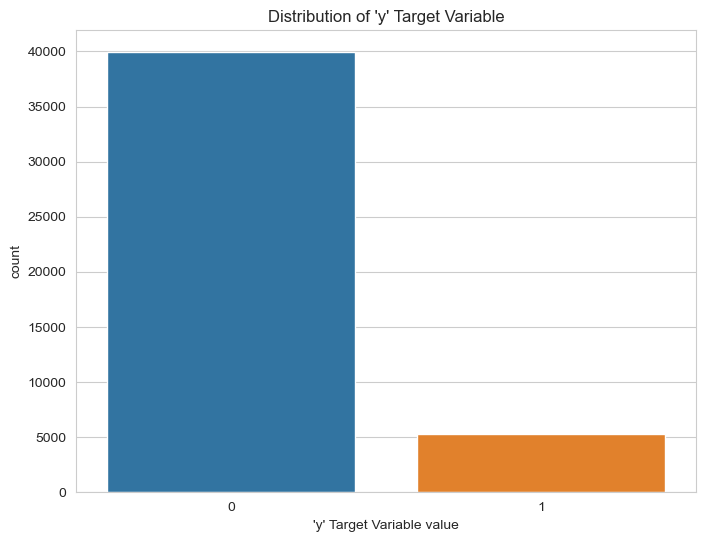

<Figure size 640x480 with 0 Axes>

In [28]:
# Visualize the data distribution of y results in the dataset using a count plot.
sns.set_style("whitegrid")
plt.figure(figsize=(8,6))
sns.countplot(x=y.values, data=shuffled_data)
plt.title("Distribution of 'y' Target Variable")
plt.xlabel("'y' Target Variable value")
plt.show()
# Save the plot as PNG file
plt.savefig("target_distribution.png")

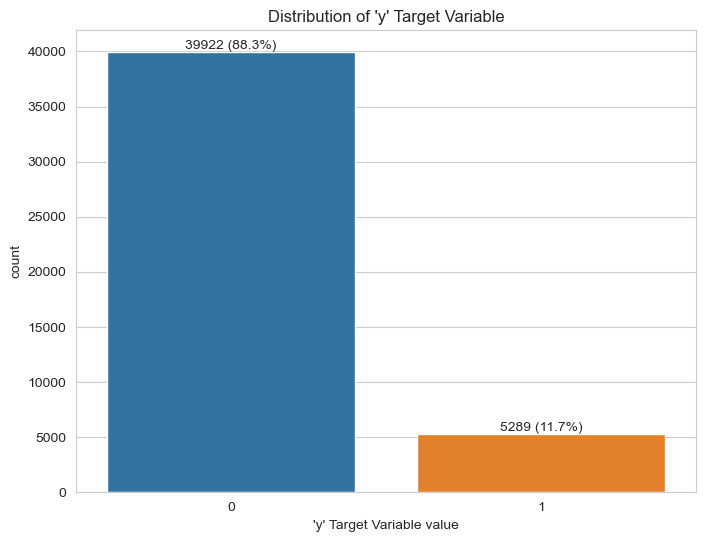

<Figure size 640x480 with 0 Axes>

In [82]:
sns.set_style("whitegrid")
plt.figure(figsize=(8,6))
ax = sns.countplot(x=y.values, data=shuffled_data)
plt.title("Distribution of 'y' Target Variable")
plt.xlabel("'y' Target Variable value")

# Label each bar with count value and percentage
total = len(shuffled_data)
for p in ax.patches:
    count = p.get_height()
    percentage = '{:.1f}%'.format(100 * count / total)
    x = p.get_x() + p.get_width() / 2
    y = p.get_y() + p.get_height()
    ax.annotate('{} ({})'.format(count, percentage), (x, y), ha='center', va='bottom')

plt.show()
# Save the plot as PNG file
plt.savefig("target_distribution.png")

In [81]:
# Create a correlation matrix
corr_matrix = shuffled_data.corr()

# Create a heatmap figure using Plotly
fig = go.Figure(
    data=go.Heatmap(
        z=corr_matrix.values,
        x=corr_matrix.columns,
        y=corr_matrix.index,
        colorscale='Viridis',
        colorbar=dict(title='Correlation')
    )
)

# Update the layout
fig.update_layout(
    title='Correlation Heatmap',
    xaxis=dict(title='Columns'),
    yaxis=dict(title='Columns')
)

# Display the figure
fig.show()
plt.savefig("heatmap.png")

<Figure size 640x480 with 0 Axes>

# Data Preprocessing

In [30]:
## Try Recursive Feature Elimination that applies Logistic Regression 
# mnodeling to the data and reduces the featuers to the top 15, 30, 45
# It failed to converge --- ! Try scaling the data 

In [59]:
# Split data into X and y
X = shuffled_data.drop('y', axis=1)
y = shuffled_data['y']
y = y.iloc[:,0]
model = LogisticRegression()

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the training set
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Scale the test set using the scaler fitted on the training set
X_test_scaled = scaler.transform(X_test)

# Fit the model on the scaled training set
model.fit(X_train_scaled, y_train)

# Evaluate the model on the scaled test set
y_pred = model.predict(X_test_scaled)

In [60]:
# try again to use Recursive Feature Selection to reduce the feature set
# initialize the model
logistic_model = LogisticRegression()

# initialize RFE
rfe = RFE(logistic_model, n_features_to_select=30)

# fit RFE
rfe.fit(X_test_scaled, y_test)

# Get the selected features
selected_features = X_test.columns[rfe.support_]
print(selected_features)

Index(['housing', 'loan', 'job_blue-collar', 'job_entrepreneur',
       'job_housemaid', 'job_management', 'job_self-employed', 'job_services',
       'job_technician', 'job_unemployed', 'marital_married', 'marital_single',
       'education_tertiary', 'contact_unknown', 'month_aug', 'month_jan',
       'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov',
       'month_oct', 'month_sep', 'poutcome_success', 'default', 'housing',
       'loan', 'duration', 'campaign', 'pdays'],
      dtype='object')


In [ ]:
# so it seems like Recursive Feature Selection is useful for reducing the data features down to a reasonable # 

# Test a Baseline Model 

In [34]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score

# Train a logistic regression model with default parameters
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)

# Predict on the test set
y_pred = lr.predict(X_test)
y_pred_proba = lr.predict_proba(X_test)[:, 1]

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_proba)
print(f"Accuracy: {accuracy:.3f}, AUC: {auc:.3f}")

Accuracy: 0.904, AUC: 0.899


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



In [61]:
baseline = (0.904+0.899)/2
print(baseline)

0.9015


BASELINE ACCURACY is 90.15%

## Run a Logistic Regression Modeling Pipeline

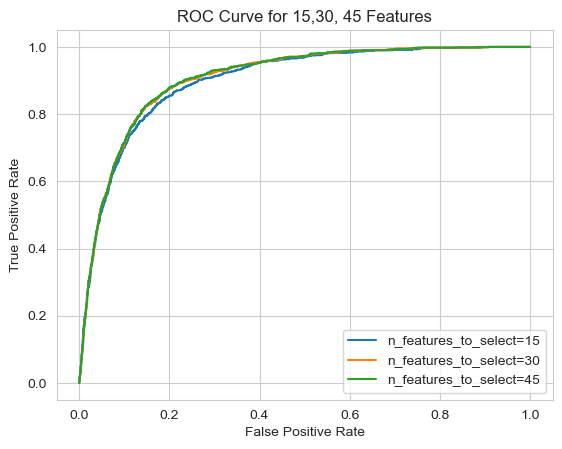

Best model:
Pipeline(steps=[('scaler', StandardScaler()),
                ('rfe',
                 RFE(estimator=LogisticRegression(max_iter=10000),
                     n_features_to_select=45)),
                ('classifier', LogisticRegression(max_iter=10000))])
Score: 0.9045225175839102


<Figure size 640x480 with 0 Axes>

In [36]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

# Define the pipeline to first scale the data, then use Recursive Feature Selection to reduce # of features
# then apply the logistic regression classifier to the model 
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('rfe', RFE(estimator=LogisticRegression(max_iter=10000))),
    ('classifier', LogisticRegression(max_iter=10000))
])

# Define the number of features to evaluate
n_features_to_select = [15, 30, 45]

# Initialize empty lists for storing accuracy and AUC scores
accuracy_scores = []
auc_scores = []

# Loop through each number of features
best_model = None
best_score = 0
for n in n_features_to_select:
    # Set the number of features for RFE
    pipe.named_steps['rfe'].n_features_to_select = n
    
    # Fit the pipeline and get accuracy score
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    acc_score = accuracy_score(y_test, y_pred)

    # Get AUC score
    y_pred_proba = pipe.predict_proba(X_test)[:,1]
    auc_score = roc_auc_score(y_test, y_pred_proba)

    # Get ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    plt.plot(fpr, tpr, label=f'n_features_to_select={n}')
    
    # Calculate and store accuracy and AUC scores
    accuracy_scores.append(accuracy_score(y_test, y_pred))
    auc_scores.append(roc_auc_score(y_test, y_pred_proba))

    # Check if this is the best model so far
    avg_score = (acc_score + auc_score) / 2
    if avg_score > best_score:
        best_score = avg_score
        best_model = pipe

# Show ROC curve
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.title("ROC Curve for 15,30, 45 Features")
plt.show()
plt.savefig("LogisticRegression ROC Curve.png")

# Print the best model and its score
print('Best model:')
print(best_model)
print(f'Score: {best_score}')

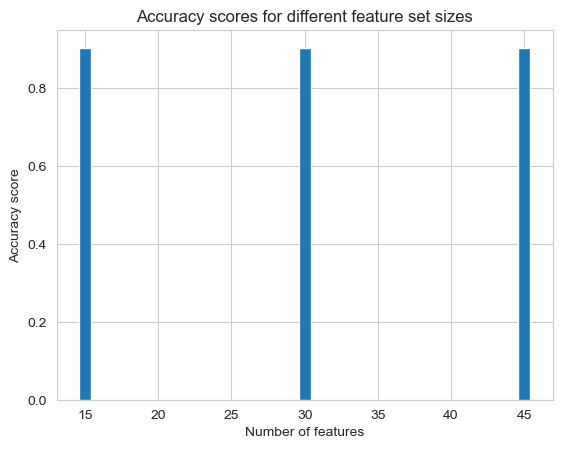

<Figure size 640x480 with 0 Axes>

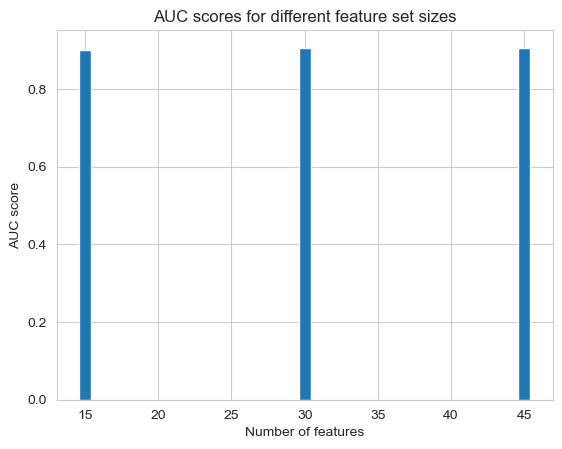

<Figure size 640x480 with 0 Axes>

In [37]:

# Create bar chart of accuracy scores
fig, ax = plt.subplots()
ax.bar([15, 30, 45], accuracy_scores)
ax.set_xlabel('Number of features')
ax.set_ylabel('Accuracy score')
ax.set_title('Accuracy scores for different feature set sizes')
plt.show()
plt.savefig("Accuracy Scores Logistic Regression.png")

# Create bar chart of AUC scores
fig, ax = plt.subplots()
ax.bar([15, 30, 45], auc_scores)
ax.set_xlabel('Number of features')
ax.set_ylabel('AUC score')
ax.set_title('AUC scores for different feature set sizes')
plt.show()
plt.savefig("AUC Scores Logistic Regression.png")

In [38]:
# Create DataFrame
scores_df = pd.DataFrame({'num_features': [15, 30, 45],
                          'accuracy': accuracy_scores,
                          'auc': auc_scores})

# Add column for average score
scores_df['avg_score'] = (scores_df['accuracy'] + scores_df['auc']) / 2

# Print DataFrame
print(scores_df)

   num_features  accuracy       auc  avg_score
0            15  0.902355  0.899445   0.900900
1            30  0.903019  0.905615   0.904317
2            45  0.902798  0.906247   0.904523


#### Therefore it seems for the Logistic Regression classification model that best model used 45 features and had an average accuracy/AUC score of 90.4% which is slightly higher than baseline of 90.15%

## Run a Decision Tree Modeling Pipeline

   n_features_selected  accuracy       auc  avg_score
0                   15  0.873272  0.691371   0.782322
1                   30  0.880460  0.709527   0.794993
2                   45  0.881345  0.714726   0.798036


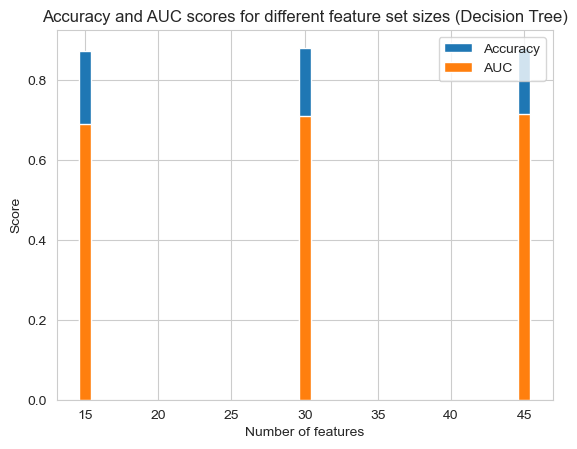

In [62]:
# Define the pipeline to first scale the data, then use Recursive Feature Selection to reduce # of features
# then apply the decision tree classifier to the model 
pipe_dt = Pipeline([
    ('scaler', StandardScaler()),
    ('rfe', RFE(estimator=DecisionTreeClassifier())),
    ('classifier', DecisionTreeClassifier())
])

# Define the number of features to evaluate
n_features_to_select = [15, 30, 45]

# Initialize empty lists for storing accuracy and AUC scores
accuracy_scores_dt = []
auc_scores_dt = []

# Loop through each number of features
for n in n_features_to_select:
    # Set the number of features for RFE
    pipe_dt.named_steps['rfe'].n_features_to_select = n
    
    # Fit the pipeline and get accuracy score
    pipe_dt.fit(X_train, y_train)
    y_pred = pipe_dt.predict(X_test)
    acc_score = accuracy_score(y_test, y_pred)

    # Get AUC score
    y_pred_proba = pipe_dt.predict_proba(X_test)[:,1]
    auc_score = roc_auc_score(y_test, y_pred_proba)

    # Calculate and store accuracy and AUC scores
    accuracy_scores_dt.append(acc_score)
    auc_scores_dt.append(auc_score)

# Create dataframe of scores
scores_dt = pd.DataFrame({
    'n_features_selected': n_features_to_select,
    'accuracy': accuracy_scores_dt,
    'auc': auc_scores_dt
})

# Add a column for the average of accuracy and AUC scores
scores_dt['avg_score'] = (scores_dt['accuracy'] + scores_dt['auc']) / 2

# Print the data
print(scores_dt)

# Create bar chart of scores
fig, ax = plt.subplots()

ax.bar(n_features_to_select, accuracy_scores_dt, label='Accuracy')
ax.bar(n_features_to_select, auc_scores_dt, label='AUC')

ax.set_xlabel('Number of features')
ax.set_ylabel('Score')
ax.set_title('Accuracy and AUC scores for different feature set sizes (Decision Tree)')
ax.legend()

# Save the plot
plt.savefig('decision_tree_scores.png')

plt.show()

In [40]:
#print decision tree scores
print(scores_dt)

   n_features_selected  accuracy       auc  avg_score
0                   15  0.859560  0.663983   0.761771
1                   30  0.883003  0.716089   0.799546
2                   45  0.882561  0.713275   0.797918


In [41]:
# print logistic regression scores
print(scores_df)

   num_features  accuracy       auc  avg_score
0            15  0.902355  0.899445   0.900900
1            30  0.903019  0.905615   0.904317
2            45  0.902798  0.906247   0.904523


The decision tree scores seem to be worse than the logistic regression scores - perhaps because decision trees can be prone to overfitting. Overfitting occurs when the model is too complex and captures noise in the data rather than the underlying patterns. This can result in poor performance on new, unseen data.

Logistic regression performed much better as a simpler model that makes fewer assumptions about the relationship between the features and the target variable. Logistic Regression is less prone to overfitting, and can perform well even when the underlying patterns in the data are complex.

### Try fine-tuning the Decision Tree hyperparameters of maximum depth and min # of samples required
### to split a node to see if results are better

In [42]:
# Define the pipeline to first scale the data, then use Recursive Feature Selection to reduce # of features
# then apply the decision tree classifier to the model
dt_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('rfe', RFE(estimator=DecisionTreeClassifier())),
    ('classifier', DecisionTreeClassifier())
])


In [43]:
# Define the hyperparameters to search over # of features to select, type of dt criterion, 
# max depth of tree, min samples for splitting further
param_grid = {
    'rfe__n_features_to_select': [30, 45],
    'classifier__criterion': ['gini', 'entropy'],
    'classifier__max_depth': [4, 6],
    'classifier__min_samples_split': [2, 4]
}


In [44]:
# Perform a grid search over the hyperparameters 
# using GridSearchCV and store the best hyperparameters and their score
grid_search = GridSearchCV(dt_pipe, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('rfe',
                                        RFE(estimator=DecisionTreeClassifier())),
                                       ('classifier',
                                        DecisionTreeClassifier())]),
             param_grid={'classifier__criterion': ['gini', 'entropy'],
                         'classifier__max_depth': [4, 6],
                         'classifier__min_samples_split': [2, 4],
                         'rfe__n_features_to_select': [30, 45]},
             scoring='accuracy')

In [45]:
# Print the best hyperparameters and their score
print(f'Best hyperparameters: {grid_search.best_params_}')
print(f'Best score: {grid_search.best_score_}')

Best hyperparameters: {'classifier__criterion': 'entropy', 'classifier__max_depth': 4, 'classifier__min_samples_split': 2, 'rfe__n_features_to_select': 30}
Best score: 0.9005196515632109


notes:
The choice between Gini and entropy as the criterion for decision tree splitting depends on the specific problem and the dataset being used. In general, both measures work well and can produce similar results, but there are some differences between them.

Gini impurity is a measure of the probability of misclassifying a randomly chosen element from the set. It is often used as a default measure because it is faster to compute than entropy. Gini impurity tends to work better when the classes are well-balanced.

Entropy is a measure of the disorder or unpredictability of the data. It tends to produce more balanced trees and works better when the classes are imbalanced.


In [46]:
# Initialize empty lists for storing scores
accuracy_scores = []
auc_scores = []
params_list = []

# Loop through each combination of hyperparameters
for params in ParameterGrid(param_grid):
    # Set the hyperparameters for the pipeline
    dt_pipe.set_params(**params)

    # Fit the pipeline and get accuracy and AUC scores
    dt_pipe.fit(X_train, y_train)
    y_pred = dt_pipe.predict(X_test)
    y_pred_proba = dt_pipe.predict_proba(X_test)[:, 1]
    accuracy = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba)

    # Calculate and store the average score
    avg_score = (accuracy + auc) / 2
    accuracy_scores.append(accuracy)
    auc_scores.append(auc)
    params_list.append(params)

# Create a DataFrame to display the results
results_df = pd.DataFrame({
    'params': params_list,
    'accuracy': accuracy_scores,
    'auc': auc_scores,
    'avg_score': [(a + b) / 2 for a, b in zip(accuracy_scores, auc_scores)]
})

# Split the params column into multiple columns
params_df = pd.json_normalize(results_df['params'])
params_df.columns = [f"{col}_param" for col in params_df.columns]

# Sort the results by the average score in descending order
results_df = results_df.sort_values('avg_score', ascending=False)
# Concatenate the results DataFrame and the params DataFrame
results_df = pd.concat([results_df, params_df], axis=1)

# Round the scores to 3 decimal places for readability
results_df = results_df.round(3)

# Drop the original params column
results_df.drop('params', axis=1, inplace=True)

# Print the results DataFrame
print(results_df)



    accuracy    auc  avg_score classifier__criterion_param  \
13     0.903  0.881      0.892                     entropy   
12     0.903  0.881      0.892                     entropy   
14     0.903  0.881      0.892                     entropy   
15     0.902  0.880      0.891                     entropy   
4      0.902  0.862      0.882                        gini   
7      0.902  0.862      0.882                        gini   
5      0.902  0.862      0.882                        gini   
6      0.902  0.862      0.882                        gini   
8      0.899  0.855      0.877                     entropy   
9      0.899  0.855      0.877                     entropy   
10     0.899  0.855      0.877                     entropy   
11     0.899  0.855      0.877                     entropy   
0      0.901  0.844      0.872                        gini   
1      0.901  0.844      0.872                        gini   
2      0.901  0.844      0.872                        gini   
3      0

The best performing Decision Tree model used 30 parameters, entropy method tuypically better for unbalanced data,
a max depth of 6 and minimum # for asplit of 2 to produce an average accuracy/auc score of 89.2%


In [47]:
# Define the pipeline to first scale the data, then use Recursive Feature Selection to reduce 
# the number of features, then apply the decision tree classifier to the model
dt_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('rfe', RFE(estimator=DecisionTreeClassifier(), n_features_to_select=30)),
    ('classifier', DecisionTreeClassifier(max_depth=6, min_samples_split=2, criterion='entropy'))
])

# Fit the pipeline on the training data
dt_pipe.fit(X_train, y_train)

# Predict on the test set
y_pred = dt_pipe.predict(X_test)
y_pred_proba = dt_pipe.predict_proba(X_test)[:, 1]

feature_imp = dt_pipe.named_steps['classifier'].feature_importances_


# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_proba)
print(f"Accuracy: {accuracy:.3f}, AUC: {auc:.3f} ")
# Print the results of the grid search
print("Best Parameters: ", grid_search.best_params_)
print("Best Score: ", grid_search.best_score_)
print("Average Score: ", np.mean(grid_search.cv_results_['mean_test_score']))
print(feature_imp)



Accuracy: 0.903, AUC: 0.881 
Best Parameters:  {'classifier__criterion': 'entropy', 'classifier__max_depth': 4, 'classifier__min_samples_split': 2, 'rfe__n_features_to_select': 30}
Best Score:  0.9005196515632109
Average Score:  0.8997213597834641
[0.05707389 0.00198129 0.00068297 0.00078095 0.         0.
 0.00241304 0.         0.00121342 0.         0.0951322  0.02126316
 0.00172158 0.         0.         0.01021909 0.010073   0.00223585
 0.00410991 0.01347491 0.         0.24094383 0.00273405 0.00258912
 0.         0.00639209 0.51577916 0.00276595 0.00345129 0.00296925]


In [ ]:
from sklearn.tree import export_graphviz
from IPython.display import Image
import pydotplus

# Export the decision tree to a DOT file
dot_data = export_graphviz(dt_pipe.named_steps['classifier'], out_file=None,
                           feature_names=X_train.columns,
                           class_names=['No Term Loan', 'Term Loan'],
                           filled=True, rounded=True,
                           special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data)

# Print the decision tree graph
Image(graph.create_png())

## Run a SVM Modeling Pipeline

Use Support Vector Classification - a type of supervised machine learning for classification tasks - to assign a label to a newinput based on a set of features.SVC works by finding a hyperplane that separates the different classes in the input data, and then using this hyperplane to classify new data points. The hyperplane is found by maximizing the margin between the different classes, i.e., the distance between the hyperplane and the closest data points from each class.

SVC can be used for both linear and nonlinear classification problems by using different types of kernels, which transform the input data into a higher-dimensional feature space where the classes are more easily separable.

In [63]:
# Define the pipeline to first scale the data, then use Recursive Feature Selection to reduce # of features
# then apply the SVM classifier to the model

rfc = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=5, max_features='sqrt')

svm_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('rfe', RFE(estimator=rfc, n_features_to_select=30, importance_getter='feature_importances_')),
    ('classifier', SVC())
])

# Define the hyperparameters to search over
param_grid = {
    'classifier__kernel': ['linear', 'poly'],
    'classifier__C': [1, 0.1],
    'classifier__degree': [2]
}

# Perform a grid search over the hyperparameters using 5-fold cross-validation
svm_grid = GridSearchCV(svm_pipe, param_grid, cv=3)
svm_grid.fit(X_train, y_train)

# Print the best hyperparameters and score
print("Best Hyperparameters:", svm_grid.best_params_)
print("Best Score:", svm_grid.best_score_)

Best Hyperparameters: {'classifier__C': 1, 'classifier__degree': 2, 'classifier__kernel': 'poly'}
Best Score: 0.8959024552090246


In [ ]:
# The SVM model was taking forever to run and wasn't finishing - even reducing the # of grid search hyperparameters to try
# defines a pipeline that uses a Random Forest Classifier to perform Recursive Feature Selection before 
# applying a Support Vector Machine Classifier to the data. It then performs a grid search over the 
# hyperparameters of the SVM classifier using cross-validation.


In [ ]:
# finally finishing the SVM Model only had a 89.6% score which was surprising

## Run a KNN Modeling Pipeline

In [69]:
# try a simple KNN model 
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

# Predict the labels of the test data
y_pred = knn.predict(X_test)

# Compute accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.8844410040915626


In [73]:
# Define the pipeline
knn_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('rfe', RFE(estimator=KNeighborsClassifier(), n_features_to_select=45)),
    ('classifier', KNeighborsClassifier())
])

# Define the grid of hyperparameters to search over
knn_param_grid = {
    'classifier__n_neighbors': [2, 5, 8]
}

# Perform grid search cross-validation to find the best hyperparameters
knn_grid_search = GridSearchCV(knn_pipe, knn_param_grid, cv=5, scoring='accuracy')
knn_grid_search.fit(X_train, y_train)

# Print the best hyperparameters and the corresponding accuracy score
print("Best hyperparameters:", knn_grid_search.best_params_)
print("Accuracy:", knn_grid_search.best_score_)

Best hyperparameters: {'classifier__n_neighbors': 8}
Accuracy: 0.8950176136843389


In [ ]:
# the best accuracy for KNN is 89.5% 

## COMPARE THE MODELS

In [76]:
# compare the test predictios for all models:
# create a dictionary with the actual y_test values and predictions from each model
test_prediction_data = {'baseline': "90.15%",
                       'Logistic Regression': "90.5%",
                       'Decision Tree': "90.3%",
                       'SVM': "89.6%",
                       'kNN':"89.5%" }

# set the float format to display full numbers
pd.options.display.float_format = '{:.2f}'.format

# create a dataframe using the dictionary
test_prediction_dataframe = pd.DataFrame(test_prediction_data, index=[0])

# display the dataframe
print(test_prediction_dataframe)

  baseline Logistic Regression Decision Tree    SVM    kNN
0   90.15%               90.5%         90.3%  89.6%  89.5%


### Findings/TakeAways: 
---  

##### Best Classification Model 
Of the four different classification methods analyzed it seems like: Logistic Regression is the winner for this dataset with the modeling techniquesand hyperparameters chosen. 

SVM tries to find the best boundary between classes using a hyperplane in higher dimensional space. KNN classifies a data point by the majority vote of it's nearest neighbors. Decision tree tries to split the data based on set boundary decision points in a tree. Logistic regression tries to use a logistic function to estimate the probability of an input belonging to a particulaar class. The model calculates a weighted sum of the input features, and then applies the logistic function to the result to produce a probability value between 0 and 1.

Logistic Regression might be the winner because it workswell with binary classification problems like the banking marketing dataset yes/no target. It is alos less prone to overfitting like Decision Trees, kNN or SVM especially whenthe dataset is unbalanced - since the marketing dataset is highly unbalanced with the majority of instances being negative (no term deposit subscription). It is also a lot faster than the other models kNN or SVM that took a long time to run for the large datset. 


 

# RANKING FEATURE IMPORTANCE

In logistic regression, the magnitude of the estimated coefficients (also known as weights) indicates the importance of each feature in predicting the target variable. Specifically, a large positive or negative coefficient indicates that the corresponding feature has a strong impact on the predicted probability of the positive class.


##### --- Key Factor for Determining Campaign Success 
· Correct and concise interpretation of descriptive and inferential statistics
· Clearly stated findings in their own section with actionable items highlighted in appropriate language for a non-technical audience

In [ ]:
# run the winning logistic regression model and capture the ranking of features

In [78]:
# run the logistic regression pipeline with 45 features 
logreg_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('rfe', RFE(estimator=LogisticRegression(max_iter=10000), n_features_to_select=45)),
    ('classifier', LogisticRegression(max_iter=10000))
])

# Fit the pipeline to the training data
logreg_pipe.fit(X_train, y_train)

# Get the feature importances
coefficients = logreg_pipe.named_steps['classifier'].coef_[0]
features = logreg_pipe.named_steps['rfe'].get_support()
feature_names = X_train.columns[features]

# Create a dataframe of the top 30 features and their coefficients
top_features = pd.DataFrame({
    'feature': feature_names,
    'coefficient': coefficients[features]
})

# Sort the features by coefficient magnitude
top_features = top_features.reindex(top_features['coefficient'].abs().sort_values(ascending=False).index)

# Print the top 30 features and their coefficients
print(top_features.head(30))

                feature  coefficient
41             duration         1.09
20      contact_unknown        -0.71
33     poutcome_success         0.42
25            month_jul        -0.31
42             campaign        -0.31
21            month_aug        -0.26
29            month_nov        -0.25
24            month_jan        -0.24
28            month_may        -0.20
17   education_tertiary         0.19
38              housing        -0.17
1               housing        -0.17
27            month_mar         0.16
3       job_blue-collar        -0.12
26            month_jun         0.12
16  education_secondary         0.11
30            month_oct         0.10
31            month_sep         0.10
40                  day         0.10
14      marital_married        -0.10
5         job_housemaid        -0.08
18    education_unknown         0.07
39                 loan        -0.07
2                  loan        -0.07
6        job_management        -0.07
9          job_services        -0.06
4

It appears like the heatmap indicated that the last contact duration feature (how long the customer was on thecall) is the most important determinant of the
customer doing a term desposit, 
The feature poutcome_success also has a positive correlation with a postive outcome so if the last time was a success its positively correlated.

The three features 'contact_unknown', 'campaign contact times', 'month_jul' are negatively correlated with success. 

### Business Recommendations: 
-- Definitely target customers that had a positive campaign outcome again to be repeat customers as well as those that had a past longer duration of calls.
-- Avoid running Campaigns during summer months of July and August and the holiday Thanksgiving month of November that have a negative correlation with success


## NEXT STEPS

 -- a deeper assessment of each of the features and it's importance on the model should be done
-- additional hyperparameter values could be tested
